In [20]:
import os, requests, xlrd, timestring, warnings, locale, decimal, sys
warnings.filterwarnings('ignore')
locale.setlocale( locale.LC_ALL, '' ) #this used to format currency

import pandas as pd
import numpy as np
import pandas_datareader as web

path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\private_data'
from IPython.display import Markdown as md
from IPython.display import display, HTML

from yahoo_fin.stock_info import *
from yahoo_fin import stock_info as si
from yahoo_fin import news
import yahooquery
from yahooquery import Ticker
import yfinance as yf
from yahoofinancials import YahooFinancials

from datetime import datetime, date, timedelta
from time import strptime

import matplotlib.pyplot as plt
plt.style.use('bmh')
# plt.rcParams["figure.figsize"] = (12,15)
from palettable.colorbrewer.qualitative import Pastel1_7
import altair as alt
import plotly.express as px

sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import data_visualization.heat_map as heat_map


<h1 align="center"> Market Monitoring</h1>
<h3 align="center">{{date.today().strftime('%Y-%m-%d')}}</h3>
<h2>Market Summary</h2>
<h3> Index Summary</h3>

In [2]:
def plot_subplot(data, x_var, title, color = 'blue'):
    plt.rcParams["figure.figsize"] = (18,12)
    fin_index = data.columns.values.tolist()
    fin_index.remove(x_var)
    numrow = int(len(fin_index)/2)
    fig, axs = plt.subplots(nrows=numrow, ncols=2, sharex=True, sharey=False)
    fig.suptitle(title, fontsize=16, y=0.9)
    for i in range(numrow):
        for j in range(2):
            axs[i,j].plot(data[x_var], 
                          data[fin_index[i*2+j]], 
                          label = fin_index[i*2+j], 
                          color = color)
            axs[i,j].legend(fontsize=10, frameon=False, loc = 'lower right')

            
start_dt = str(date.today()- timedelta(days=365))
end_dt = str(date.today())

SP_TSX = get_data("^GSPTSE", start_date = start_dt, end_date = end_dt)
SP500 = get_data("^GSPC", start_date = start_dt, end_date = end_dt)
DOWJ = get_data("^DJI", start_date = start_dt, end_date = end_dt)
NASDAQ = get_data("^IXIC", start_date = start_dt, end_date = end_dt)
VIX = get_data("^VIX", start_date = start_dt, end_date = end_dt)
NIKKEI = get_data("^N225", start_date = start_dt, end_date = end_dt)
HANGSENG = get_data("^HSI", start_date = start_dt, end_date = end_dt)
SHANGHAI = get_data("000001.SS", start_date = start_dt, end_date = end_dt)

financial_index_smr = pd.DataFrame({"SP_TSX": SP_TSX["adjclose"],
                      "SP500": SP500["adjclose"],
                      "DOWJ": DOWJ["adjclose"],
                      "NASDAQ": NASDAQ["adjclose"],
                      "NIKKEI": NIKKEI["adjclose"],
                      "HANGSENG": HANGSENG["adjclose"],
                      "SHANGHAI": SHANGHAI["adjclose"],
                      "VIX": VIX["adjclose"]})
financial_index_smr = financial_index_smr.fillna(method='ffill').reset_index()
fin_index = financial_index_smr.columns[1:].values

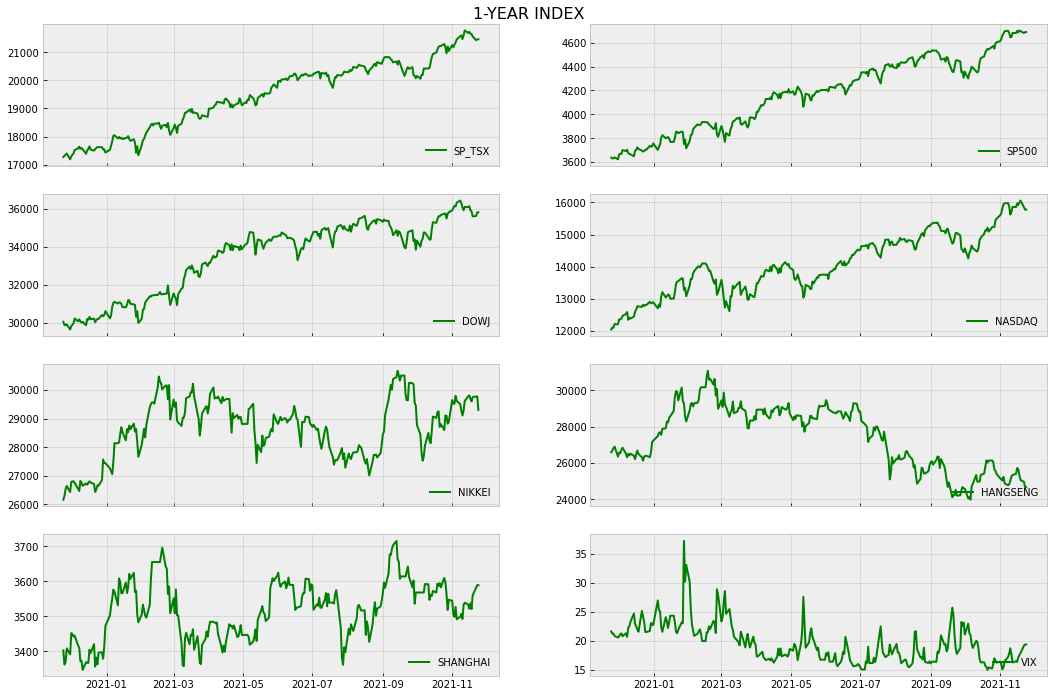

In [3]:
plot_subplot(financial_index_smr, 'index', '1-YEAR INDEX', color = 'green')

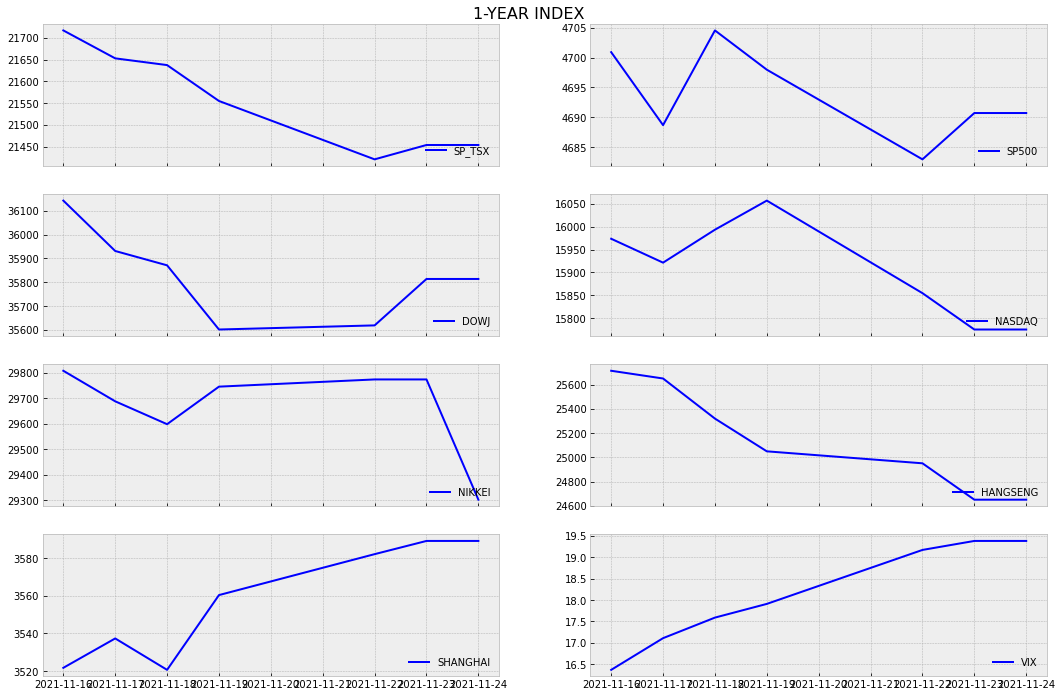

In [4]:
plot_subplot(financial_index_smr.tail(7), 'index', '1-WEEK INDEX', color = 'blue')

### Product Summary

In [5]:
commodity_futures = ['GC=F', 'SI=F', 'CL=F', '^TNX', 'CAD=X', 'CADCNY=X']
index_map = {
    'GC=F': 'Gold', 
    'SI=F': 'Silver', 
    'CL=F': 'Crude Oil',
    '^TNX': 'CBOE 10Y Bond',
    'CAD=X': 'USD/CAD',
    'CADCNY=X': 'CAD/CNY'
}
yahoo_financials_commodities = YahooFinancials(commodity_futures)
daily_commodity_prices = yahoo_financials_commodities.get_historical_price_data(start_dt, end_dt, 'daily')
product = []
date = []
price = []
for i in daily_commodity_prices:
    for j in daily_commodity_prices[i]['prices']:
        product.append(index_map[i])
        date.append(j['formatted_date'])
        price.append(j['adjclose'])

product_smr = pd.DataFrame(
    {'Product': product,
     'Date': date,
     'Price': price
    })

product_smr = product_smr.pivot_table(index=["Date"],  columns='Product',  values='Price')
product_smr = product_smr.reset_index()
product_smr = product_smr.fillna(method='ffill')
product_smr['Date'] = product_smr['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())


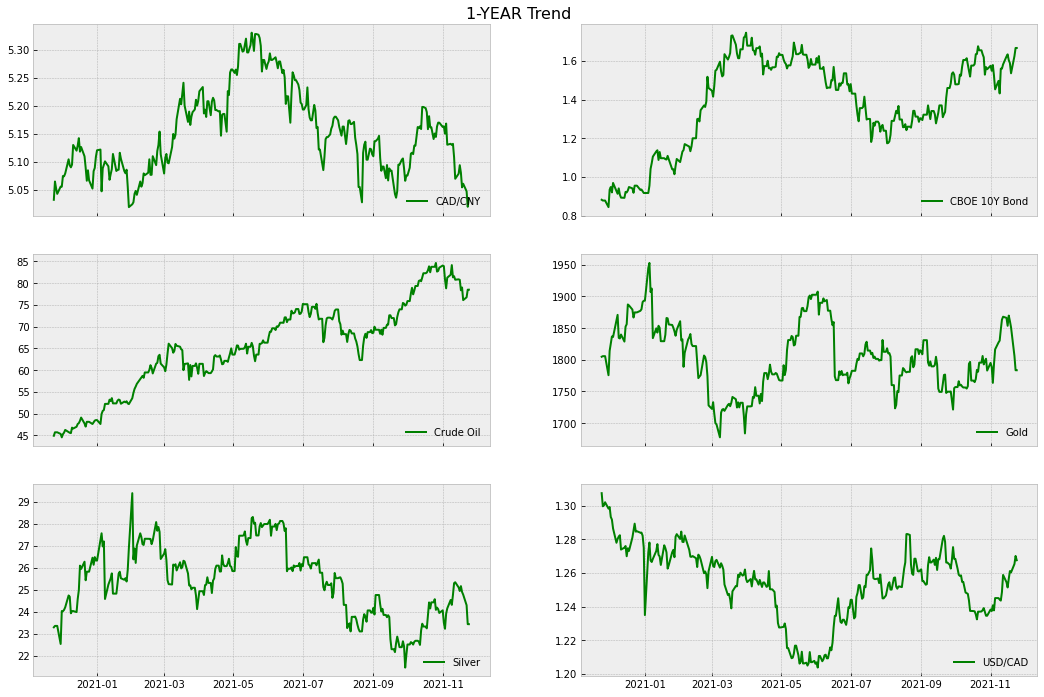

In [6]:
plot_subplot(product_smr, 'Date', '1-YEAR Trend', color = 'green')

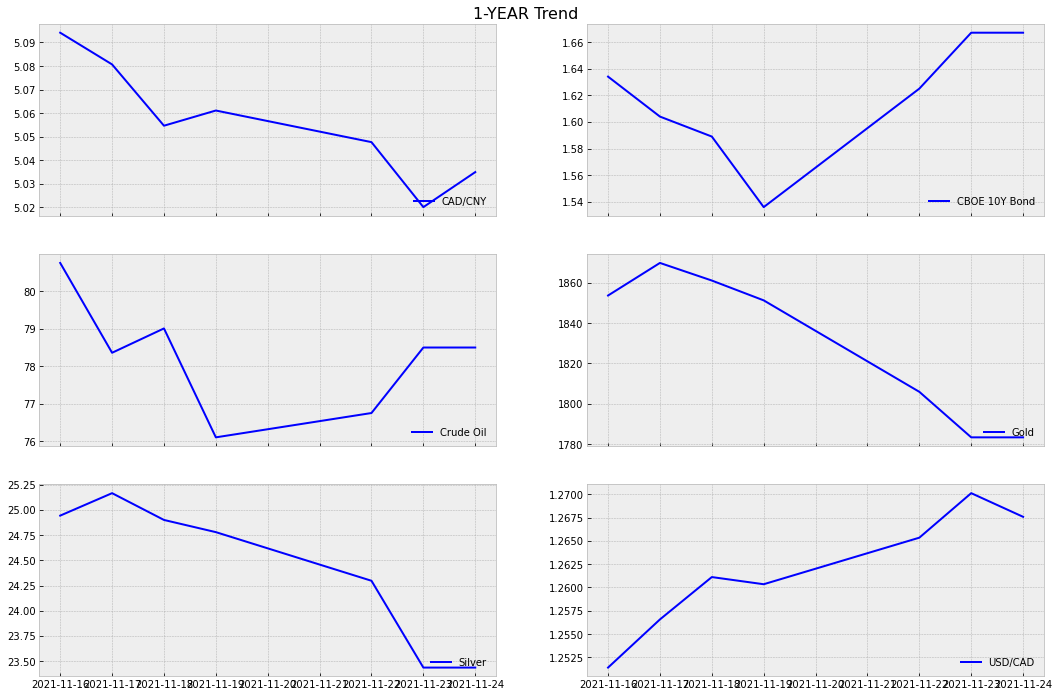

In [7]:
plot_subplot(product_smr.tail(7), 'Date', '1-WEEK Trend', color = 'blue')

### Gainer/Loser Summary 

In [8]:
def format_cap(x):
    pre_format = str(x).replace('T','e+12')
    aft_format = "{:.0f}".format(decimal.Decimal(pre_format))
    return int(aft_format)
def show_split_table(data):
    n_row = int(len(data)/2)
    table1 = data.head(n_row)
    table2 = data.tail(n_row)
    output = pd.concat([d.reset_index(drop=True) for d in [table1, table2]], axis=1)
    display(HTML(output.to_html(index=False)))
def drop_topn_records(data, sort_var, n):
    data = data.sort_values(by=[sort_var], ascending=False)
    output = data.iloc[n: , :]
    return output
tol_n_to_show = 20
split_n = tol_n_to_show/2
outlier_n = 3

In [9]:
most_active = si.get_day_most_active()
most_active.columns = ['Symbol','Name','Price','Change','Price_Change%','Volume','Avg_vol','Market_Cap','PE_Ratio']
most_active = most_active[['Symbol','Name','Price_Change%','Market_Cap','Volume']].head(tol_n_to_show)
most_active['Market_Cap']=most_active['Market_Cap'].apply(lambda x: format_cap(x))
most_active_noOutlier = drop_topn_records(most_active, 'Market_Cap', outlier_n)

most_gain = si.get_day_gainers()
most_gain.columns = ['Symbol','Name','Price','Change','Price_Change%','Volume','Avg_vol','Market_Cap','PE_Ratio']
most_gain = most_gain[['Symbol','Name','Price_Change%','Market_Cap','Volume']].head(tol_n_to_show)
most_gain['Market_Cap']=most_gain['Market_Cap'].apply(lambda x: format_cap(x))
most_gain_noOutlier = drop_topn_records(most_gain, 'Market_Cap', outlier_n)

most_lose = si.get_day_losers()
most_lose.columns = ['Symbol','Name','Price','Change','Price_Change%','Volume','Avg_vol','Market_Cap','PE_Ratio']
most_lose = most_lose[['Symbol','Name','Price_Change%','Market_Cap','Volume']].head(tol_n_to_show)
most_lose['Market_Cap']=most_lose['Market_Cap'].apply(lambda x: format_cap(x))
most_lose_noOutlier = drop_topn_records(most_lose, 'Market_Cap', outlier_n)


**Most Active Stocks**

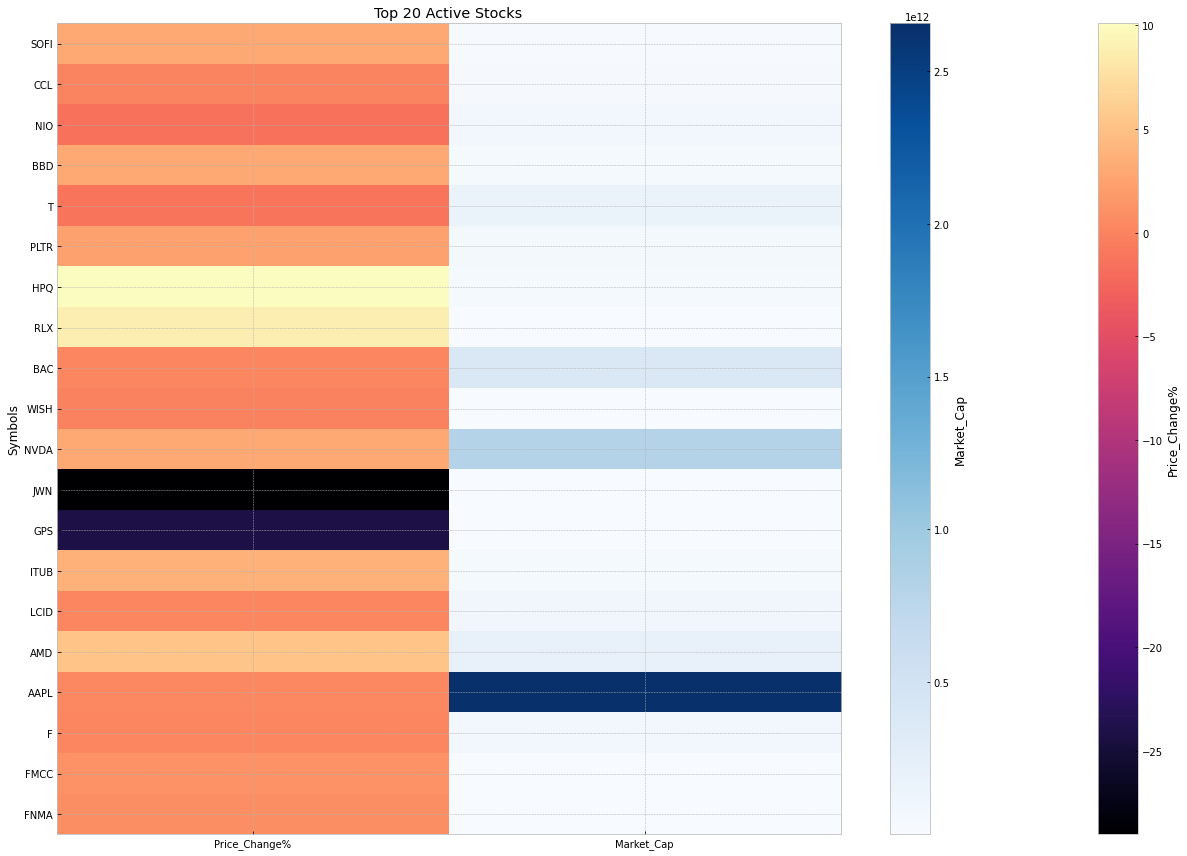

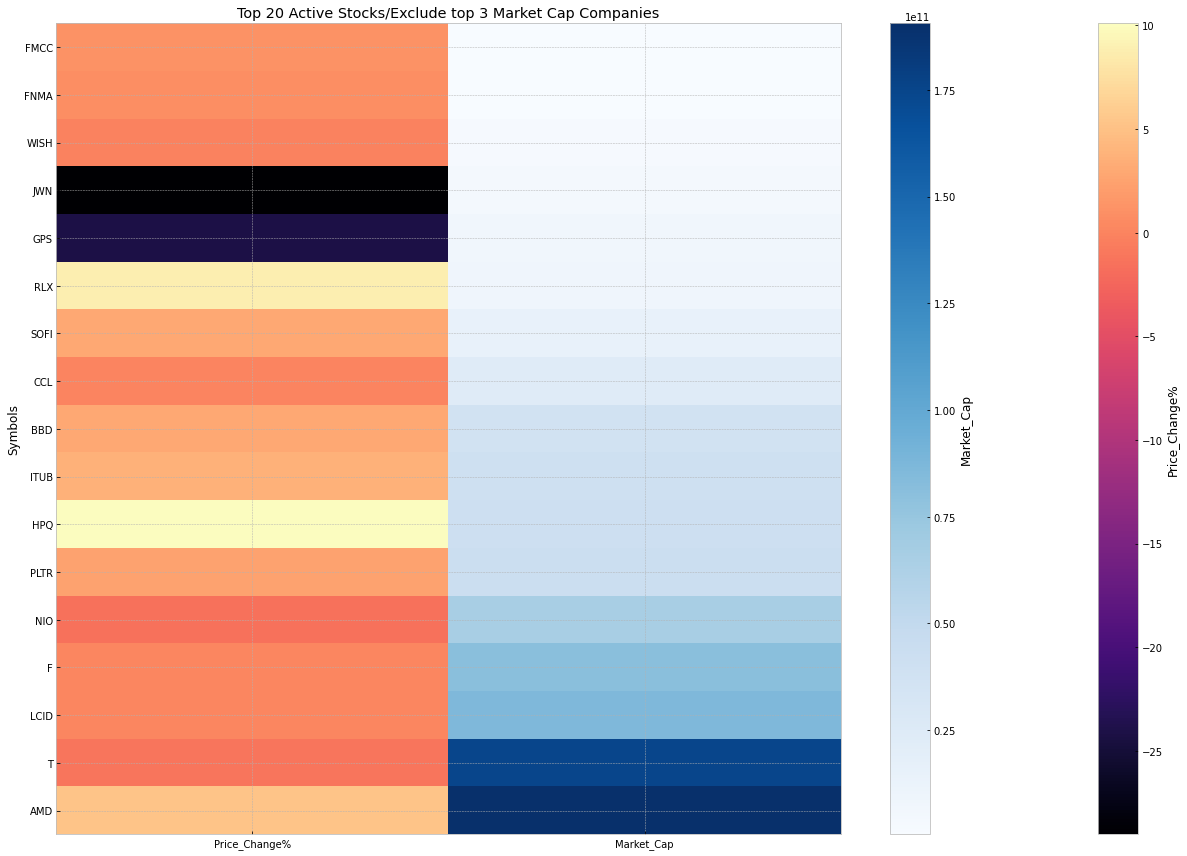

In [10]:
show_split_table(most_active)
heat_map.two_dim_heatmap(most_active, 'Symbol', 'Price_Change%', 'Market_Cap', 'Symbols', 'Top 20 Active Stocks')
heat_map.two_dim_heatmap(most_active_noOutlier, 'Symbol', 'Price_Change%', 'Market_Cap', 'Symbols', "Top 20 Active Stocks/Exclude top 3 Market Cap Companies")


**Most Gain**

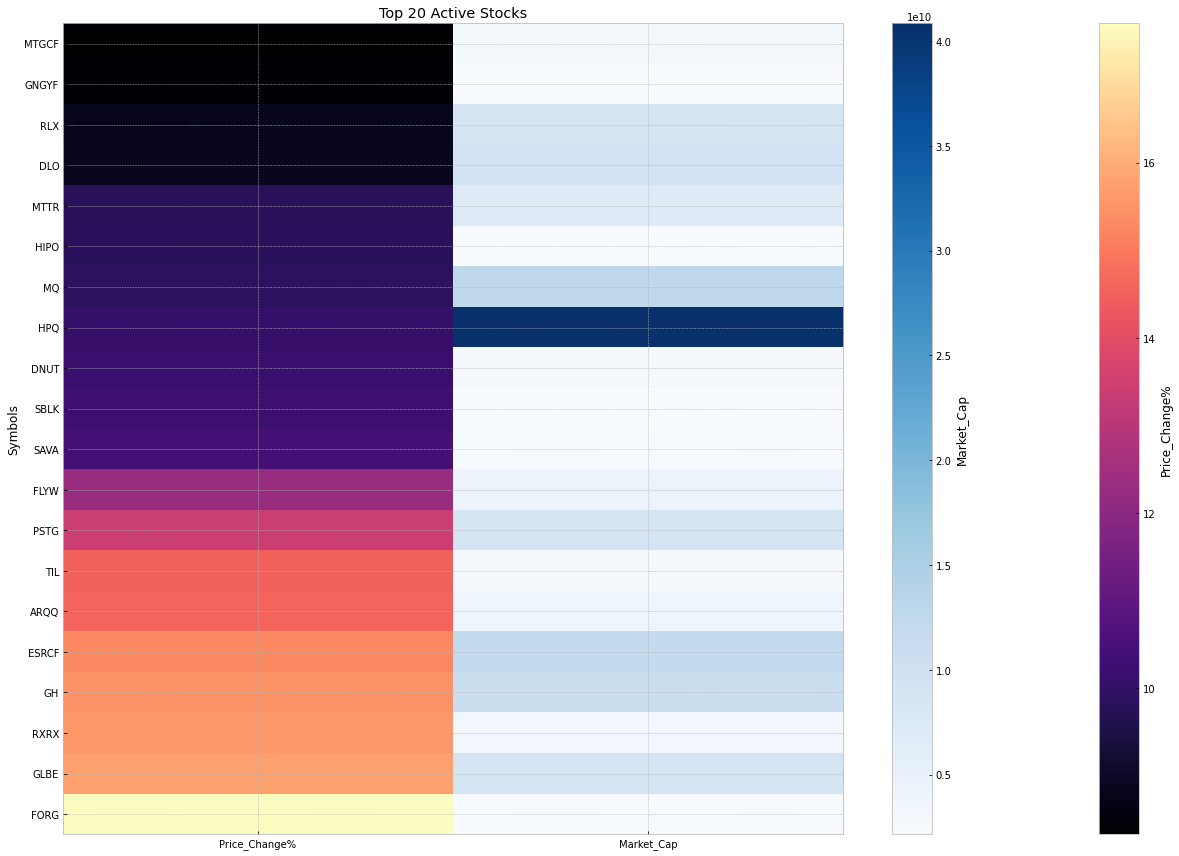

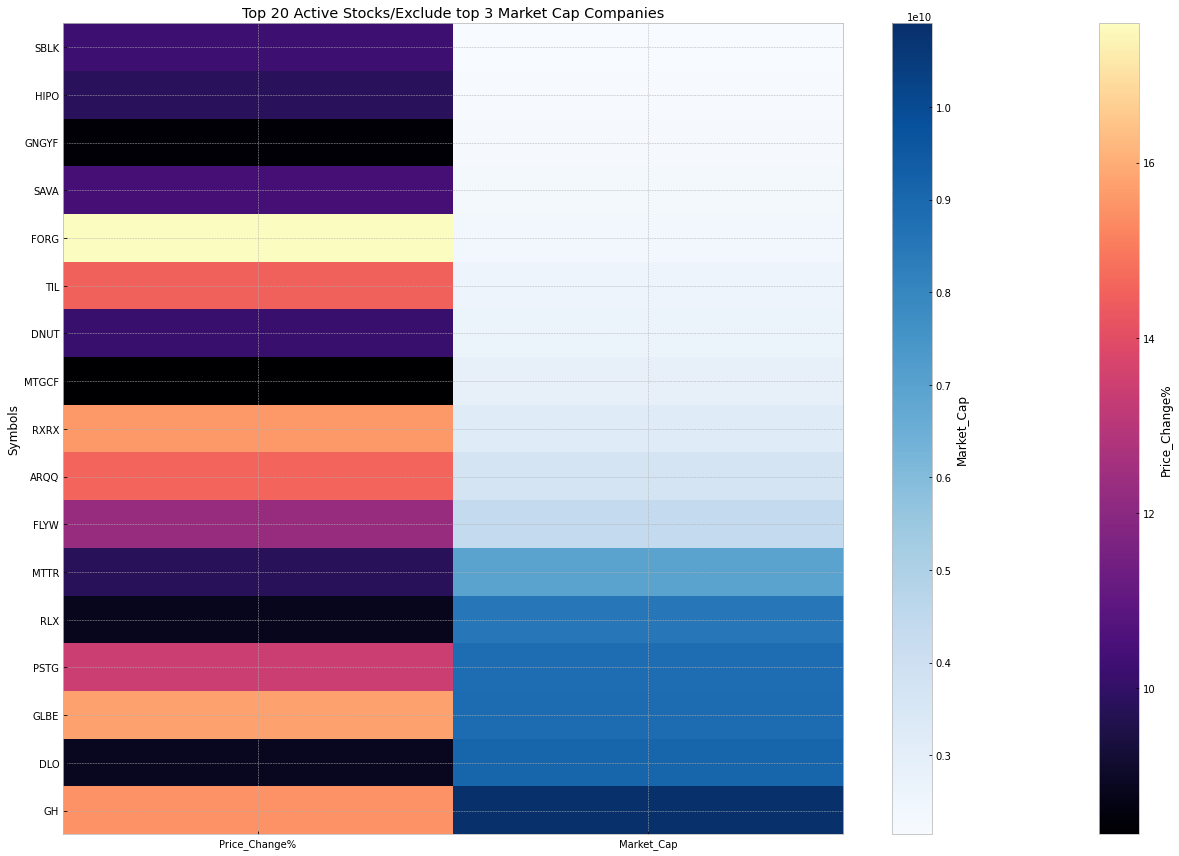

In [11]:
show_split_table(most_gain)
heat_map.two_dim_heatmap(most_gain, 'Symbol', 'Price_Change%', 'Market_Cap', 'Symbols', 'Top 20 Gain Stocks')
heat_map.two_dim_heatmap(most_gain_noOutlier, 'Symbol', 'Price_Change%', 'Market_Cap', 'Symbols', "Top 20 Gain Stocks/Exclude top 3 Market Cap Companies")


**Most Lose**

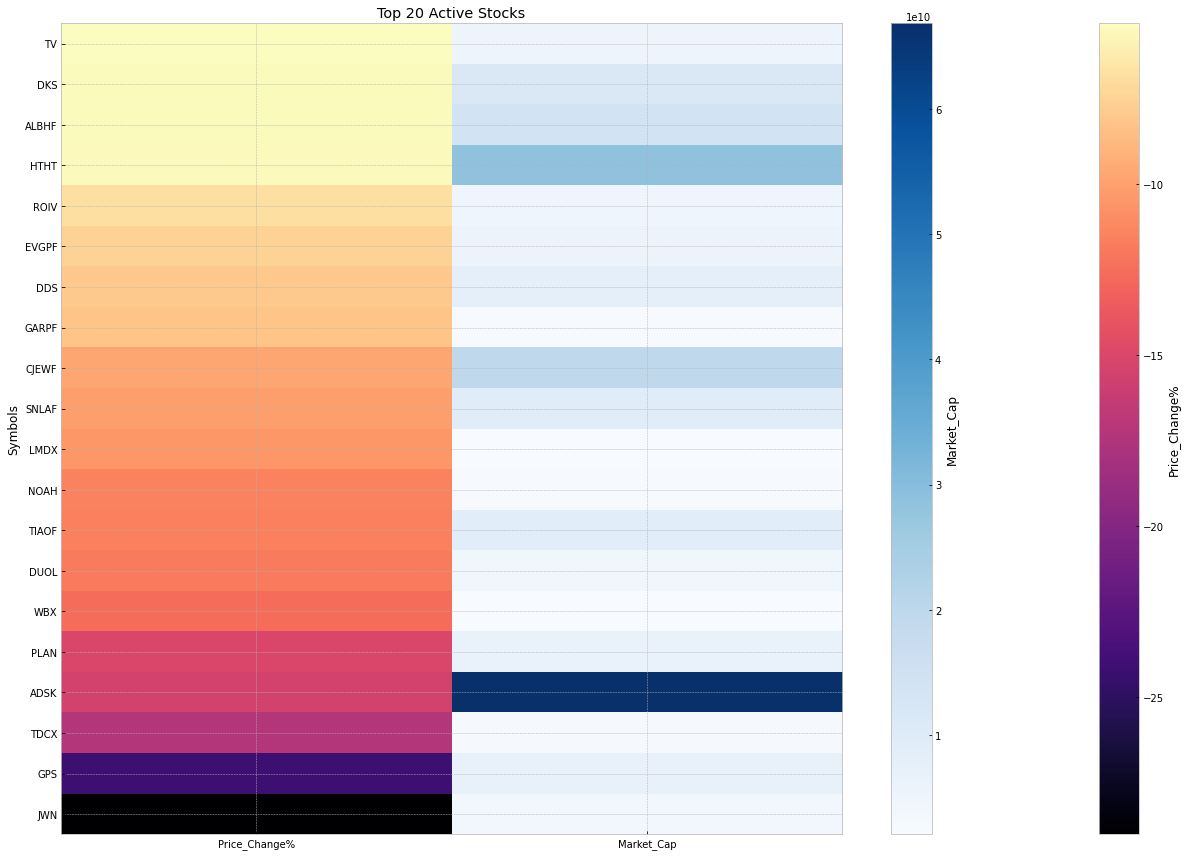

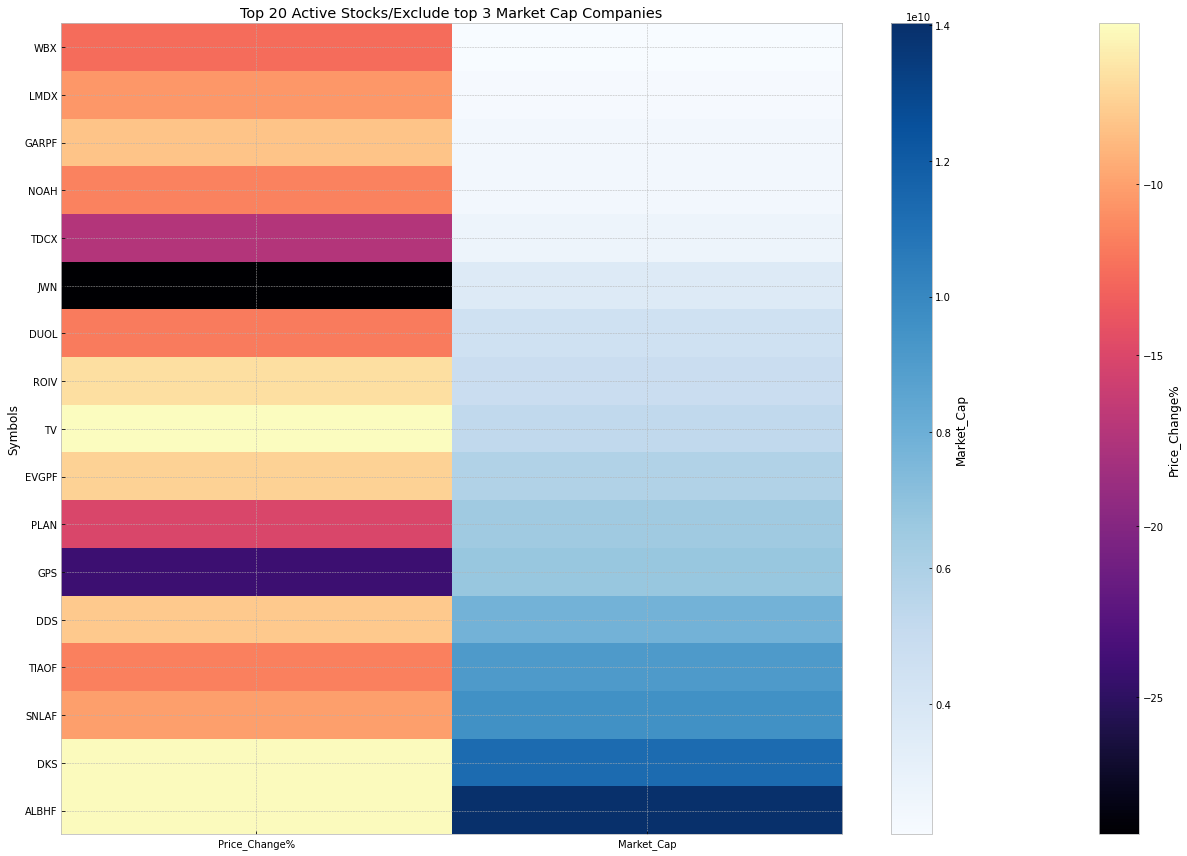

In [12]:
show_split_table(most_lose)
heat_map.two_dim_heatmap(most_lose, 'Symbol', 'Price_Change%', 'Market_Cap', 'Symbols', 'Top 20 Lose Stocks')
heat_map.two_dim_heatmap(most_lose_noOutlier, 'Symbol', 'Price_Change%', 'Market_Cap', 'Symbols', "Top 20 Lose Stocks/Exclude top 3 Market Cap Companies")


## Fund Summary

In [13]:


# ===================================== Functions

# def get_stock_details(tickers, startdate, enddate):
#     output = pd.DataFrame()
#     for ticker in tickers:
#         tmp = si.get_data(ticker, start_date = startdate, end_date = enddate)
#         output = output.append(tmp)
#     output['date'] = output.index
#     return output
def get_stock_details(tickers, startdate, enddate):
    output = pd.DataFrame()
    for ticker in tickers:
        tmp = yf.Ticker(ticker).history(start = startdate, end = enddate)
        tmp['ticker'] = ticker
        output = output.append(tmp)
    output = output.reset_index()
    return output


def plot_pie_chart_dist(data, group_by_feature, dist_feature, optional_title = ''):
#     CSS = """
#     .output {
#         display: flex;
#         flex-direction: row;
#         flex-flow: wrap;
#     }
#     """

#     display(HTML('<style>{}</style>'.format(CSS)))
    # plot link: https://python-graph-gallery.com/161-custom-matplotlib-donut-plot/
    data_smr = pd.DataFrame(data.groupby(group_by_feature)[dist_feature].agg('sum').round(0))
#     display(HTML(data_smr.to_html()))
    data_smr[group_by_feature] = data_smr.index

    my_circle=plt.Circle( (0,0), 0.5, color='white')
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

    total = sum(data_smr[dist_feature])
    def label_format(x):
        return('{:.1f}%\n({:.0f})'.format(x, total*x/100))
    plt.pie(data_smr[dist_feature], 
            labels=data_smr.index, 
            colors=Pastel1_7.hex_colors, 
            autopct=label_format,
            wedgeprops = { 'linewidth' : 15, 'edgecolor' : 'white' })
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(optional_title + dist_feature + ' distribution by different ' + group_by_feature)
    plt.show()

    
def get_etf_holding(ticker, price_period = '2y'):

    t = Ticker(ticker)
    hist_price = t.history(period=price_period, interval='1d')
    hist_price = hist_price.reset_index()
#     price = pd.melt(hist_price, id_vars=['date'], value_vars=['open', 'high', 'close', 'low', 'adjclose'])
#     fig = px.line(price, x='date', y='value', color='variable',
#                  title=ticker+' Historical Price')
    fig = px.line(hist_price, x='date', y='adjclose', 
                 title=ticker+' Historical Price')
    fig.show()
#     fig = px.line(hist_price, x='date', y='volume', 
#                  title=ticker+' Volume')
#     fig.show()
    print('===============================',ticker,'=================================')
    print()
    print('-------------------------- Summary Details ----------------------------')
    if type(t.summary_detail[ticker]) != str:
        smr_details = pd.DataFrame(t.summary_detail[ticker], index=[0]).T.set_axis(['Value'], axis=1, inplace=False)
        keep_cols = ['totalAssets', 'previousClose', 'open', 'fiftyDayAverage','fiftyDayAverage',
                 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'twoHundredDayAverage',
                 'volume','averageVolume', 'averageVolume10days','averageDailyVolume10Day']
        smr_details = smr_details[smr_details.index.isin(keep_cols)]
        smr_details = smr_details.reindex(keep_cols)
        display(smr_details)
    print('-------------------------- Key Factor ----------------------------')
    if type(t.key_stats[ticker]) != str:
        key_factor = pd.DataFrame(t.key_stats[ticker], index=[0]).T.set_axis(['Value'], axis=1, inplace=False)
        key_factor = key_factor[key_factor.index.isin(['category','ytdReturn','fundFamily', 'fundInceptionDate', 'legalType'])]
        display(key_factor)
    print('-------------------------- Fund Sector ----------------------------')
    if type(t.fund_sector_weightings[ticker]) != str:
        fund_sector = t.fund_sector_weightings
        if len(fund_sector) >1:
            fund_sector.insert(0,'Fund Sector',fund_sector.index)
            fund_sector = fund_sector.reset_index(drop=True)
            fund_sector.columns = ['Fund Sector','Percentage']
            fund_sector = fund_sector.sort_values(by='Percentage', ascending=False)
        display(fund_sector)
    print('-------------------------- Holdings ----------------------------')
    if type(t.fund_holding_info[ticker]) != str:
        display(pd.DataFrame(t.fund_holding_info[ticker]['holdings']))
    print('-------------------------- Returns ----------------------------')
    if type(t.fund_performance[ticker]) != str:
        display(pd.DataFrame(t.fund_performance[ticker]['performanceOverview'], index=[0]).T.set_axis(['Value'], axis=1, inplace=False))
        print()
        display(pd.DataFrame(t.fund_performance[ticker]['trailingReturns'], index=[0]).T.set_axis(['Value'], axis=1, inplace=False))
        print()
        display(pd.DataFrame(t.fund_performance[ticker]['annualTotalReturns']['returns']))
    print('-------------------------- Risk Factors ----------------------------')
    if type(t.fund_performance[ticker]) != str:
        display(pd.DataFrame(t.fund_performance[ticker]['riskOverviewStatistics']['riskStatistics']))
    print('=========================================================================')
                           

def print_news_title(ticker, filter_date):
    news_raw = news.get_yf_rss(ticker)
    n_news = len(news_raw)
    print('Recent News of', ticker, ':')
    for i in range(n_news):
        newsdate = news_raw[i].published
        newsdate = datetime(int(newsdate.split(' ')[3]), int(strptime(newsdate.split(' ')[2],'%b').tm_mon), int(newsdate.split(' ')[1]), 0, 0, 0)
        if newsdate >= timestring.Date(filter_date).date:
            print('-------------------------------------------------------------')
            print(news_raw[i].title)
    print('================================================================')

def get_news_given_ticker(ticker, filter_date):
    news_raw = news.get_yf_rss(ticker)
    n_news = len(news_raw)
    cols = ['title','date','summary','link']
    output = pd.DataFrame(columns=cols)
    print('News for', ticker)
    for i in range(n_news):
        newsdate = news_raw[i].published
        newsdate = datetime(int(newsdate.split(' ')[3]), int(strptime(newsdate.split(' ')[2],'%b').tm_mon), int(newsdate.split(' ')[1]), 0, 0, 0)
#         output.loc[i,'title'] = news_raw[i].title
#         output.loc[i,'date'] = newsdate
#         output.loc[i,'summary'] = news_raw[i].summary
#         output.loc[i,'link'] = news_raw[i].link
#     output = output[output.date >= timestring.Date(filter_date).date].drop(columns = 'date')
#     return output
        if newsdate >= timestring.Date(filter_date).date:
            print('-------------------------------------------------------------')
            print(news_raw[i].title)
            print(news_raw[i].summary)
            print(news_raw[i].link)
    print('================================================================')


In [14]:
#=========================== Load File
file = 'stock_smr.xlsx'
holding_tranc = 'holding_transaction'
cash_tranc = 'cash_transaction'

from datetime import datetime, timedelta
# td = str((datetime.today() - timedelta(days = max(1, (datetime.today().weekday() + 6) % 7 - 3))).strftime('%m/%d/%Y'))
# lstyear = str((datetime.strptime(td, '%m/%d/%Y') + timedelta(days = -365)).strftime('%m/%d/%Y'))
# lstqtr = str((datetime.strptime(td, '%m/%d/%Y') + timedelta(days = -90)).strftime('%m/%d/%Y'))
# tmr = str((datetime.strptime(td, '%m/%d/%Y') + timedelta(days = 1)).strftime('%m/%d/%Y'))

td = str((datetime.today() - timedelta(days = max(1, (datetime.today().weekday() + 6) % 7 - 3))).strftime('%Y-%m-%d'))
tmr = str((datetime.strptime(td, '%Y-%m-%d') + timedelta(days = 1)).strftime('%Y-%m-%d'))
lstyear = str((datetime.strptime(td, '%Y-%m-%d') + timedelta(days = -365)).strftime('%Y-%m-%d'))
lstqtr = str((datetime.strptime(td, '%Y-%m-%d') + timedelta(days = -90)).strftime('%Y-%m-%d'))


initial_fund = pd.read_excel(os.path.join(path,file), sheet_name = cash_tranc)
stock_tranc = pd.read_excel(os.path.join(path,file), sheet_name = holding_tranc)
stock_tranc['total_amt'] = -1 * stock_tranc['amount_per_share'] * stock_tranc['share']

#=========================== Get Cash Value
initial_fund = initial_fund[initial_fund.date<datetime.strptime(td,'%Y-%m-%d')]
stock_tranc = stock_tranc[stock_tranc.date<datetime.strptime(td,'%Y-%m-%d')]

initial_fund_CAD = initial_fund[initial_fund.currency == 'CAD']['value'].sum()
initial_fund_USD = initial_fund[initial_fund.currency == 'USD']['value'].sum()
current_cash_CAD = initial_fund[initial_fund.currency == 'CAD']['value'].sum() + stock_tranc[stock_tranc.currency=='CAD']['total_amt'].agg('sum')
current_cash_USD = initial_fund[initial_fund.currency == 'USD']['value'].sum() + stock_tranc[stock_tranc.currency=='USD']['total_amt'].agg('sum')
current_cash ={
    'currency': ['CAD','USD'],
    'value': [current_cash_CAD, current_cash_USD]
}
current_cash = pd.DataFrame(current_cash)
# curr_cadusd = pd.to_numeric(si.get_data('CADUSD=X', start_date = td, end_date = tmr).sort_index(ascending=False).head(1).adjclose)[0]
curr_cadusd = yf.Ticker("CADUSD=X").history(start = td, end = tmr).sort_index(ascending=True).head(1).Close[0]

#=========================== Get Market Value
current_hold = stock_tranc.groupby('ticker')['share','total_amt'].agg('sum')
current_hold['cost'] = current_hold.total_amt / current_hold.share
current_hold = current_hold.reset_index()
current_hold = current_hold.merge(stock_tranc[['ticker', 'category', 'currency', 'products']], how = 'left', on = 'ticker')

active_stock_ticker = current_hold.ticker.unique()
hold_stock_detail = get_stock_details(active_stock_ticker, lstqtr, td)

from pandasql import sqldf, load_meat, load_births
pysqldf = lambda q: sqldf(q, globals())

stock_curr_price = hold_stock_detail[hold_stock_detail.Close.notnull()].sort_values(by = ['Date'], ascending=False).groupby('ticker').head(3)
stock_curr_price['rank'] = stock_curr_price.groupby('ticker')['Date'].rank(method = 'first', ascending = False)


In [15]:
# Get Current Holdings
current_hold = stock_tranc.groupby('ticker')['share','total_amt'].agg('sum')
current_hold['cost'] = current_hold.total_amt / current_hold.share
current_hold = current_hold.reset_index()
current_hold = current_hold.merge(stock_tranc[['ticker', 'category', 'currency', 'products']], how = 'left', on = 'ticker')
# print(current_hold)

active_stock_ticker = current_hold.ticker.unique()
hold_stock_detail = get_stock_details(active_stock_ticker, lstqtr, td)

from pandasql import sqldf, load_meat, load_births
pysqldf = lambda q: sqldf(q, globals())

stock_curr_price = hold_stock_detail[hold_stock_detail.Close.notnull()].sort_values(by = ['Date'], ascending=False).groupby('ticker').head(3)
stock_curr_price['rank'] = stock_curr_price.groupby('ticker')['Date'].rank(method = 'first', ascending = False)
query = """
    SELECT 
        A.ticker
        , A.currency
        , A.share
        , A.cost as unit_cost
        , C.Close as lastday_price
        , B.Close as today_price
        , round(A.total_amt) as total_cost
        , round(case when A.ticker = 'CASH' then A.cost else B.Close * A.share end) as curr_value
        , round((B.Close + A.cost) * A.share) as profit
        , round(-1 * B.Close / A.cost - 1, 2) as today_roe
        , round(B.Close / C.Close - 1, 4)  as today_ir
        , A.category
        , A.products
    FROM 
        current_hold A
    LEFT JOIN 
        stock_curr_price B on A.ticker = B.ticker and B.rank = 1
    LEFT JOIN 
        stock_curr_price C on A.ticker = C.ticker and C.rank = 2
        
    UNION
    
    SELECT 
        'CASH' as ticker
        , currency
        , '' as share
        , '' as unit_cost
        , '' as lastday_price
        , '' as today_price
        , '' as total_cost
        , round(value) as curr_value
        , '' as profit
        , '' as today_roe
        , '' as today_ir
        , 'CASH' as category
        , 'CASH' as products
    
    FROM current_cash
    """
stock_curr_smr = pysqldf(query)
stock_curr_smr.insert(11,'value_in_cad', np.where(stock_curr_smr['currency'] == 'CAD', stock_curr_smr['curr_value'], round(stock_curr_smr['curr_value']/curr_cadusd)))
display(stock_curr_smr)


ticker currency   share unit_cost lastday_price today_price  \
0  0P00016N6T.TO      CAD  109.17    -36.64         41.73       41.63   
1           CASH      CAD                                               
2           CASH      USD                                               
3         ENB.TO      CAD      80    -36.12         50.27       50.13   
4         HGU.TO      CAD      75    -32.54         18.08       17.42   
5         HUZ.TO      CAD     250    -12.37         11.81        11.6   
6         HZU.TO      CAD      90    -23.41         14.99       14.47   
7           SPCE      USD      70    -16.94         17.25       17.08   
8            VDE      USD      57    -51.82            77       78.23   

  total_cost  curr_value profit today_roe today_ir  value_in_cad category  \
0      -4000      4545.0    545      0.14  -0.0024        4545.0       IT   
1                26798.0                                 26798.0     CASH   
2                17207.0                                 21855.0     CASH   
3      -2890      4010.0   1121      0.39  -0.0028        4010.0      OIL   
4      -2441      1307.0  -1134     -0.46  -0.0365        1307.0     GOLD   
5      -3093      2900.0   -192     -0.06  -0.0178        2900.0   SILVER   
6      -2107      1302.0   -805     -0.38  -0.0347        1302.0   SILVER   
7      -1186      1196.0     10      0.01  -0.0099        1519.0    SPACE   
8      -2954      4459.0   1505      0.51    0.016        5664.0      OIL   

  products  
0   MUTUAL  
1     CASH  
2     CASH  
3    STOCK  
4      ETF  
5      ETF  
6      ETF  
7    STOCK  
8      ETF

## Holdings Summary
### Portfolio Summary

In [16]:
description = ['Initial Fund', 'Current Cash', 'Investment%', 'Market Value', 'Profit', 'ROC']
CAD = [
    locale.currency(initial_fund_CAD, grouping=True),
    locale.currency(current_cash_CAD, grouping=True),
    "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum()-current_cash_CAD)/stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum()),
    locale.currency(stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum(), grouping=True),
    locale.currency(stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() - initial_fund_CAD, grouping=True),
    "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() - initial_fund_CAD)/initial_fund_CAD)]
USD = [
    locale.currency(initial_fund_USD, grouping=True),
    locale.currency(current_cash_USD, grouping=True),
    "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum()-current_cash_USD)/stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum()),
    locale.currency(stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum(), grouping=True),
    locale.currency(stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum() - initial_fund_USD, grouping=True),
    "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum() - initial_fund_USD)/initial_fund_USD)
]
ALL_IN_CAD = [
    locale.currency(initial_fund_CAD + initial_fund_USD/curr_cadusd, grouping=True),
    locale.currency(current_cash_CAD + current_cash_USD/curr_cadusd, grouping=True),
    "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() + stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum()/curr_cadusd - current_cash_CAD - current_cash_USD/curr_cadusd) / (stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() + stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum()/curr_cadusd)),
    locale.currency(stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() + stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum()/curr_cadusd, grouping=True),
    locale.currency((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() - initial_fund_CAD) + (stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum() - initial_fund_USD) /curr_cadusd , grouping=True),
    "{:.1%}".format(((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() - initial_fund_CAD) + (stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum() - initial_fund_USD) /curr_cadusd)/(initial_fund_CAD + initial_fund_USD/curr_cadusd)) 
]
portfolio_smr = pd.DataFrame(
    {'Description': description,
     'CAD': CAD,
     'USD': USD,
     'All_in_CAD': ALL_IN_CAD
    })
print('Portfolio Summary Generated on:',td)
display(portfolio_smr)

Portfolio Summary Generated on: 2021-11-23


Description         CAD         USD  All_in_CAD
0  Initial Fund  $41,327.00  $21,347.00  $68,440.47
1  Current Cash  $26,797.51  $17,207.46  $48,653.22
2   Investment%       34.4%       24.7%       30.4%
3  Market Value  $40,862.00  $22,862.00  $69,899.71
4        Profit   ($465.00)   $1,515.00   $1,459.25
5           ROC       -1.1%        7.1%        2.1%

## Holdings Summary
### Portfolio Summary {{ td }}

* Initial Fund: CAD: {{ locale.currency(initial_fund_CAD, grouping=True) }}, USD: {{ locale.currency(initial_fund_USD, grouping=True)}}, All in CAD: {{ locale.currency(initial_fund_CAD + initial_fund_USD/curr_cadusd, grouping=True)}}.
* Current Cash: CAD: {{locale.currency(current_cash_CAD, grouping=True)}}, USD: {{locale.currency(current_cash_USD, grouping=True)}}, All in CAD: {{locale.currency(current_cash_CAD + current_cash_USD/curr_cadusd, grouping=True)}}
* Investment Percentage: CAD: {{ "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum()-current_cash_CAD)/stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum())}}, USD: {{ "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum()-current_cash_USD)/stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum())}}, Overall: {{ "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() + stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum()/curr_cadusd - current_cash_CAD - current_cash_USD/curr_cadusd) / (stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() + stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum()/curr_cadusd))}}
* Market Value: CAD: {{locale.currency(stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum(), grouping=True)}}, USD: {{locale.currency(stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum(), grouping=True)}}, All in CAD: {{locale.currency(stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() + stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum()/curr_cadusd, grouping=True) }}
* Profit: CAD: {{locale.currency(stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() - initial_fund_CAD, grouping=True)}}, USD: {{locale.currency(stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum() - initial_fund_USD, grouping=True)}}, All in CAD: {{locale.currency((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() - initial_fund_CAD) + (stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum() - initial_fund_USD) /curr_cadusd , grouping=True)}}
* ROE: CAD: {{ "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() - initial_fund_CAD)/initial_fund_CAD) }}, USD: {{ "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum() - initial_fund_USD)/initial_fund_USD) }}, Overall: {{ "{:.1%}".format(((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() - initial_fund_CAD) + (stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum() - initial_fund_USD) /curr_cadusd)/(initial_fund_CAD + initial_fund_USD/curr_cadusd)) }}

## Fund Distribution

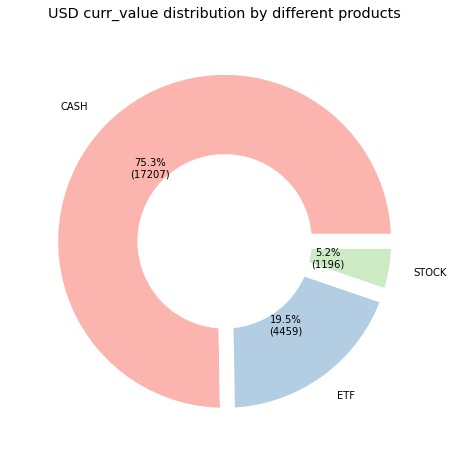

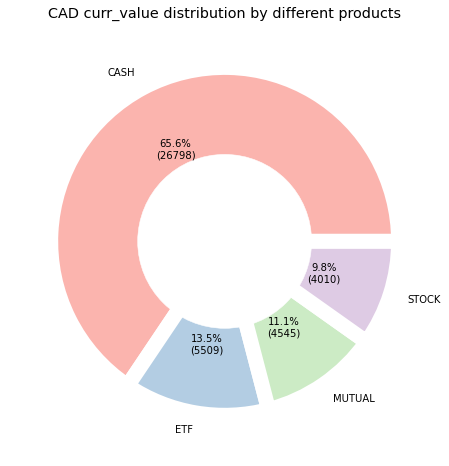

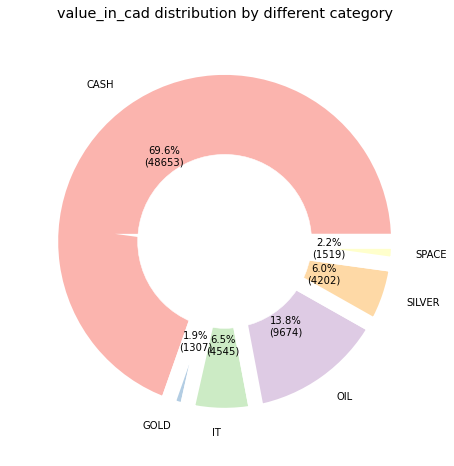

In [17]:
plot_pie_chart_dist(stock_curr_smr[stock_curr_smr.currency=='USD'], 'products', 'curr_value', 'USD ')
plot_pie_chart_dist(stock_curr_smr[stock_curr_smr.currency=='CAD'], 'products', 'curr_value', 'CAD ')
plot_pie_chart_dist(stock_curr_smr, 'category', 'value_in_cad')

## Current Holdings Market Watch

In [18]:
alt.Chart(hold_stock_detail).mark_line().encode(x='Date',y='Volume', color = 'ticker:N')



alt.Chart(...)

In [19]:
for ticker in stock_curr_smr.ticker.values:
    if ticker != 'CASH':
        print_news_title(ticker, td)
        get_etf_holding(ticker, '1y') #'1mo'

Recent News of 0P00016N6T.TO :


=============================== 0P00016N6T.TO =================================

-------------------------- Summary Details ----------------------------


Value
totalAssets              2024229632
previousClose                 38.58
open                            NaN
fiftyDayAverage             39.2612
fiftyDayAverage             39.2612
fiftyTwoWeekLow               16.73
fiftyTwoWeekHigh              38.07
twoHundredDayAverage        36.2143
volume                          NaN
averageVolume                     0
averageVolume10days               0
averageDailyVolume10Day           0

-------------------------- Key Factor ----------------------------


Value
category                          None
fundFamily                        None
fundInceptionDate  2015-10-19 20:00:00
legalType                         None

-------------------------- Fund Sector ----------------------------


Fund Sector  Percentage
4               technology      0.5880
5   communication_services      0.1770
1        consumer_cyclical      0.1681
6       financial_services      0.0533
0               realestate      0.0135
2          basic_materials      0.0000
3       consumer_defensive      0.0000
7                utilities      0.0000
8              industrials      0.0000
9                   energy      0.0000
10              healthcare      0.0000

-------------------------- Holdings ----------------------------


symbol                                holdingName  holdingPercent
0    SE.SI                                Sea Ltd ADR          0.0542
1     AMZN                             Amazon.com Inc          0.0443
2  2330.TW  Taiwan Semiconductor Manufacturing Co Ltd          0.0396
3  SHOP.TO                              Shopify Inc A          0.0387
4     TEAM                Atlassian Corporation PLC A          0.0322
5     CRWD           CrowdStrike Holdings Inc Class A          0.0308
6     WDAY                        Workday Inc Class A          0.0290
7     TSLA                                  Tesla Inc          0.0273
8     NFLX                                Netflix Inc          0.0270
9        V                           Visa Inc Class A          0.0270

-------------------------- Returns ----------------------------


Value
morningStarReturnRating  0.0000
numYearsUp               4.0000
numYearsDown             1.0000
bestOneYrTotalReturn     0.6943
worstOneYrTotalReturn   -0.0345
bestThreeYrTotalReturn   0.6943
worstThreeYrTotalReturn  0.1033

Value
asOfDate     2021-11-22 19:00:00
ytd                     0.177494
oneMonth              -0.0442561
threeMonth             0.0086121
oneYear                 0.300726
threeYear               0.389925
fiveYear                0.178951
tenYear                        0
lastBullMkt                    0
lastBearMkt                    0

year  annualValue
0  2021          NaN
1  2020     0.694287
2  2019     0.262508
3  2018    -0.034504
4  2017     0.364726
5  2016     0.019197

-------------------------- Risk Factors ----------------------------


year  alpha  beta  meanAnnualReturn  rSquared  stdDev  sharpeRatio  \
0   5y   9.48  1.31              2.27     63.09   18.47         1.42   
1   3y  10.89  1.27              2.22     65.57   20.86         1.22   
2  10y    NaN   NaN               NaN       NaN     NaN          NaN   

   treynorRatio  
0         21.20  
1         20.78  
2           NaN

Recent News of ENB.TO :
-------------------------------------------------------------
11 Best Pipeline and MLP Stocks To Buy
-------------------------------------------------------------
Enbridge (ENB) Resumes Operations at Westcoast Gas Pipeline


=============================== ENB.TO =================================

-------------------------- Summary Details ----------------------------


Value
totalAssets                   NaN
previousClose               50.45
open                         50.4
fiftyDayAverage           51.5474
fiftyDayAverage           51.5474
fiftyTwoWeekLow             40.36
fiftyTwoWeekHigh               54
twoHundredDayAverage      48.5572
volume                    5418858
averageVolume             8328206
averageVolume10days      13055820
averageDailyVolume10Day  13055820

-------------------------- Key Factor ----------------------------


Value
category    None
fundFamily  None
legalType   None

-------------------------- Fund Sector ----------------------------
-------------------------- Holdings ----------------------------
-------------------------- Returns ----------------------------
-------------------------- Risk Factors ----------------------------
Recent News of HGU.TO :


=============================== HGU.TO =================================

-------------------------- Summary Details ----------------------------
-------------------------- Key Factor ----------------------------
-------------------------- Fund Sector ----------------------------
-------------------------- Holdings ----------------------------
-------------------------- Returns ----------------------------
-------------------------- Risk Factors ----------------------------
Recent News of HUZ.TO :


=============================== HUZ.TO =================================

-------------------------- Summary Details ----------------------------
-------------------------- Key Factor ----------------------------
-------------------------- Fund Sector ----------------------------
-------------------------- Holdings ----------------------------
-------------------------- Returns ----------------------------
-------------------------- Risk Factors ----------------------------
Recent News of HZU.TO :


=============================== HZU.TO =================================

-------------------------- Summary Details ----------------------------
-------------------------- Key Factor ----------------------------
-------------------------- Fund Sector ----------------------------
-------------------------- Holdings ----------------------------
-------------------------- Returns ----------------------------
-------------------------- Risk Factors ----------------------------
Recent News of SPCE :
-------------------------------------------------------------
Bezos’s Blue Origin to launch NFL legend Michael Strahan into space
-------------------------------------------------------------
Blue Origin Is Taking Hall of Famer Michael Strahan to Space. It’s Good News for Virgin Galactic.


=============================== SPCE =================================

-------------------------- Summary Details ----------------------------


Value
totalAssets                   NaN
previousClose               16.83
open                        16.71
fiftyDayAverage           21.3368
fiftyDayAverage           21.3368
fiftyTwoWeekLow             14.27
fiftyTwoWeekHigh             62.8
twoHundredDayAverage      28.8266
volume                    6944925
averageVolume            13648661
averageVolume10days      11200200
averageDailyVolume10Day  11200200

-------------------------- Key Factor ----------------------------


Value
category    None
fundFamily  None
legalType   None

-------------------------- Fund Sector ----------------------------
-------------------------- Holdings ----------------------------
-------------------------- Returns ----------------------------
-------------------------- Risk Factors ----------------------------
Recent News of VDE :


=============================== VDE =================================

-------------------------- Summary Details ----------------------------


Value
totalAssets              6696737792
previousClose                 80.67
open                          80.26
fiftyDayAverage             78.5936
fiftyDayAverage             78.5936
fiftyTwoWeekLow               49.74
fiftyTwoWeekHigh              84.21
twoHundredDayAverage        72.4892
volume                      1353611
averageVolume               1104403
averageVolume10days         1289960
averageDailyVolume10Day     1289960

-------------------------- Key Factor ----------------------------


Value
category                  Equity Energy
ytdReturn                        0.6417
fundFamily                     Vanguard
fundInceptionDate   2004-09-22 20:00:00
legalType          Exchange Traded Fund

-------------------------- Fund Sector ----------------------------


Fund Sector  Percentage
9                   energy      0.9977
2          basic_materials      0.0019
8              industrials      0.0005
0               realestate      0.0000
1        consumer_cyclical      0.0000
3       consumer_defensive      0.0000
4               technology      0.0000
5   communication_services      0.0000
6       financial_services      0.0000
7                utilities      0.0000
10              healthcare      0.0000

-------------------------- Holdings ----------------------------


symbol                   holdingName  holdingPercent
0    XOM              Exxon Mobil Corp          0.2195
1    CVX                  Chevron Corp          0.1656
2    COP                ConocoPhillips          0.0617
3    EOG             EOG Resources Inc          0.0401
4    SLB              Schlumberger Ltd          0.0353
5    MPC       Marathon Petroleum Corp          0.0327
6    PSX                   Phillips 66          0.0312
7    KMI     Kinder Morgan Inc Class P          0.0306
8    PXD  Pioneer Natural Resources Co          0.0281
9    WMB        Williams Companies Inc          0.0266

-------------------------- Returns ----------------------------


Value
asOfDate              2021-10-27 20:00:00
ytdReturnPct                       0.6417
oneYearTotalReturn                 1.2193
threeYearTotalReturn               0.0005

Value
asOfDate     2021-06-29 20:00:00
ytd                       0.4905
oneMonth                   0.052
threeMonth                0.1257
oneYear                   0.5738
threeYear                -0.0673
fiveYear                 -0.0107
tenYear                  -0.0087
lastBullMkt                    0
lastBearMkt                    0

year  annualValue
0   2021          NaN
1   2020    -0.330443
2   2019     0.093183
3   2018    -0.199139
4   2017    -0.024044
5   2016     0.289601
6   2015    -0.232150
7   2014    -0.099182
8   2013     0.257750
9   2012     0.034584
10  2011     0.027980
11  2010     0.210897
12  2009     0.249044
13  2008    -0.393130
14  2007     0.348651
15  2006     0.189829
16  2005     0.390454
17  2004          NaN

-------------------------- Risk Factors ----------------------------


year  alpha  beta  meanAnnualReturn  rSquared  stdDev  sharpeRatio  \
0   5y -22.00  1.90              0.42     63.79   34.58         0.11   
1   3y -27.51  2.03              0.18     73.38   42.61         0.02   
2  10y -13.01  1.58              0.27     61.25   28.45         0.09   

   treynorRatio  
0         -1.16  
1         -3.90  
2         -0.94

## Watch List

In [25]:
watchlist = pd.read_excel(os.path.join(path,file), sheet_name = 'watchlist')
watchlist_df = get_stock_details(watchlist["ticker"].unique(), lstqtr, td)

alt.Chart(watchlist_df).mark_line().encode(x='Date',y='Volume', color = 'ticker:N')


alt.Chart(...)

In [27]:
for ticker in watchlist.ticker.values:
    print_news_title(ticker, td)
    get_etf_holding(ticker, '1y')

Recent News of JETS :


=============================== JETS =================================

-------------------------- Summary Details ----------------------------


Value
totalAssets              3616804864
previousClose                  22.2
open                          22.33
fiftyDayAverage              23.375
fiftyDayAverage              23.375
fiftyTwoWeekLow               21.14
fiftyTwoWeekHigh              28.98
twoHundredDayAverage        24.6394
volume                      5506116
averageVolume               6840926
averageVolume10days         7380700
averageDailyVolume10Day     7380700

-------------------------- Key Factor ----------------------------


Value
category            Miscellaneous Sector
ytdReturn                          0.035
fundFamily         U.S. Global Investors
fundInceptionDate    2015-04-29 20:00:00
legalType           Exchange Traded Fund

-------------------------- Fund Sector ----------------------------


Fund Sector  Percentage
8              industrials      0.9158
1        consumer_cyclical      0.0740
4               technology      0.0102
0               realestate      0.0000
2          basic_materials      0.0000
3       consumer_defensive      0.0000
5   communication_services      0.0000
6       financial_services      0.0000
7                utilities      0.0000
9                   energy      0.0000
10              healthcare      0.0000

-------------------------- Holdings ----------------------------


symbol                        holdingName  holdingPercent
0    DAL                Delta Air Lines Inc          0.1001
1    UAL       United Airlines Holdings Inc          0.0987
2    LUV              Southwest Airlines Co          0.0981
3    AAL        American Airlines Group Inc          0.0953
4    ALK               Alaska Air Group Inc          0.0298
5   SNCY  Sun Country Airlines Holdings Inc          0.0297
6   ALGT                Allegiant Travel Co          0.0294
7   JBLU               JetBlue Airways Corp          0.0286
8   SKYW                        SkyWest Inc          0.0285
9  AC.TO                 Air Canada Class B          0.0284

-------------------------- Returns ----------------------------


Value
asOfDate              2021-10-27 20:00:00
ytdReturnPct                        0.035
oneYearTotalReturn                 0.3484
threeYearTotalReturn              -0.0834

Value
asOfDate     2021-06-29 20:00:00
ytd                       0.0804
oneMonth                 -0.0994
threeMonth               -0.1014
oneYear                   0.4529
threeYear                -0.0517
fiveYear                  0.0353
tenYear                        0
lastBullMkt                    0
lastBearMkt                    0

year  annualValue
0  2021          NaN
1  2020    -0.289900
2  2019     0.141013
3  2018    -0.137607
4  2017     0.183987
5  2016     0.131517
6  2015          NaN

-------------------------- Risk Factors ----------------------------


year  alpha  beta  meanAnnualReturn  rSquared  stdDev  sharpeRatio  \
0   5y  -15.0  1.70              0.77     55.71   33.07         0.24   
1   3y  -23.3  1.82              0.29     64.17   40.90         0.06   
2  10y    0.0  0.00              0.00      0.00    0.00         0.00   

   treynorRatio  
0          1.40  
1         -3.52  
2          0.00

Recent News of BKNG :
-------------------------------------------------------------
Booking Holdings to Buy Flights Partner ETraveli Group for $1.8 Billion
-------------------------------------------------------------
Booking Holdings plans $1.8 billion acquisition of Swedish flight-booking company
-------------------------------------------------------------
Booking Holdings Enters Into An Agreement With CVC Capital Partners To Acquire Etraveli Group
-------------------------------------------------------------
'The cup is half full at the moment' for the travel industry: Moody's Senior Vice President
-------------------------------------------------------------
Video Highlights: Tech Meets Vacation – Join CEO of Vacasa, Managing Partner of TPG Pace Group in Fireside Chat
-------------------------------------------------------------
4 Stocks That Can Turn $100,000 Into $500,000 by the Time You Retire


=============================== BKNG =================================

-------------------------- Summary Details ----------------------------


Value
totalAssets                  NaN
previousClose            2297.13
open                     2312.24
fiftyDayAverage          2438.43
fiftyDayAverage          2438.43
fiftyTwoWeekLow          1860.73
fiftyTwoWeekHigh         2687.29
twoHundredDayAverage     2320.85
volume                    256565
averageVolume             294526
averageVolume10days       385810
averageDailyVolume10Day   385810

-------------------------- Key Factor ----------------------------


Value
category    None
fundFamily  None
legalType   None

-------------------------- Fund Sector ----------------------------
-------------------------- Holdings ----------------------------
-------------------------- Returns ----------------------------
-------------------------- Risk Factors ----------------------------
Recent News of AWAY :


=============================== AWAY =================================

-------------------------- Summary Details ----------------------------


Value
totalAssets              381284480
previousClose                25.78
open                         25.74
fiftyDayAverage            27.9304
fiftyDayAverage            27.9304
fiftyTwoWeekLow              24.25
fiftyTwoWeekHigh             34.54
twoHundredDayAverage       29.1832
volume                      247192
averageVolume               239447
averageVolume10days         319220
averageDailyVolume10Day     319220

-------------------------- Key Factor ----------------------------


Value
category              Consumer Cyclical
ytdReturn                        0.0569
fundFamily                        ETFMG
fundInceptionDate   2020-02-11 19:00:00
legalType          Exchange Traded Fund

-------------------------- Fund Sector ----------------------------


Fund Sector  Percentage
1        consumer_cyclical      0.6179
4               technology      0.2597
5   communication_services      0.1224
0               realestate      0.0000
2          basic_materials      0.0000
3       consumer_defensive      0.0000
6       financial_services      0.0000
7                utilities      0.0000
8              industrials      0.0000
9                   energy      0.0000
10              healthcare      0.0000

-------------------------- Holdings ----------------------------


symbol                           holdingName  holdingPercent
0     ABNB  Airbnb Inc Ordinary Shares - Class A          0.0495
1     UBER                 Uber Technologies Inc          0.0480
2     BKNG                  Booking Holdings Inc          0.0445
3     LYFT                      Lyft Inc Class A          0.0445
4  MMYT.BO                        MakeMyTrip Ltd          0.0440
5    TRN.L                         Trainline PLC          0.0428
6     TCOM                Trip.com Group Ltd ADR          0.0422
7    00696      TravelSky Technology Ltd Class H          0.0411
8     EXPE                     Expedia Group Inc          0.0398
9     TRIP                       TripAdvisor Inc          0.0395

-------------------------- Returns ----------------------------


Value
asOfDate              2021-10-27 20:00:00
ytdReturnPct                       0.0569
oneYearTotalReturn                 0.4645
threeYearTotalReturn                    0

Value
asOfDate     2021-06-29 20:00:00
ytd                       0.1506
oneMonth                  -0.044
threeMonth               -0.0467
oneYear                   0.6184
threeYear                      0
fiveYear                       0
tenYear                        0
lastBullMkt                    0
lastBearMkt                    0

year
0  2021
1  2020

-------------------------- Risk Factors ----------------------------


year  alpha  beta  meanAnnualReturn  rSquared  stdDev  sharpeRatio  \
0   5y    0.0   0.0               0.0       0.0     0.0          0.0   
1   3y    0.0   0.0               0.0       0.0     0.0          0.0   
2  10y    0.0   0.0               0.0       0.0     0.0          0.0   

   treynorRatio  
0           0.0  
1           0.0  
2           0.0

## News Details
### Current Holdings

In [10]:
for ticker in stock_curr_smr.ticker.values:
    if ticker != 'CASH':
        get_news_given_ticker(ticker, td)


News for 0P00016N6T.TO
News for ENB.TO
-------------------------------------------------------------
Enbridge (ENB) Resumes Operations at Westcoast Gas Pipeline
Enbridge's (ENB) Westcoast pipeline is currently transporting 1.63 bcf/d of natural gas, which is above 100% of the total contracted volume transported last year at this time.
https://finance.yahoo.com/news/enbridge-enb-resumes-operations-westcoast-150803826.html?.tsrc=rss
-------------------------------------------------------------
UPDATE 1-Enbridge says pipeline in flood-hit Canada province transporting natural gas above year-ago level
Enbridge Inc said Monday it was now transporting more natural gas on its Westcoast natural gas pipeline than at this time in 2020, less than a week after it shut a segment of the pipeline system due to heavy flooding in the British Columbia province.  The pipeline was transporting 1.63 billion cubic feet per day (bcf/d) of natural gas as of Monday, above the 100% of total contracted volume tra

### Watch List

In [11]:
for ticker in watchlist.ticker.values:
    if ticker != 'CASH':
        get_news_given_ticker(ticker, td)


News for JETS
News for BKNG
-------------------------------------------------------------
Booking Holdings to Buy Flights Partner ETraveli Group for $1.8 Billion
Leaning into a growth area, flights, Booking Holdings announced it plans to acquire one of its flights partners, Etraveli Group, for around $1.83 billion (euro 1.63 billion). ETraveli powers Booking.com’s nascent flights’ business, which is launched over the last two years. Accommodations-oriented since its founding, Booking.com, which is the parent company’s flagship brand, now has […]
https://finance.yahoo.com/news/booking-holdings-buy-flights-partner-214059107.html?.tsrc=rss
-------------------------------------------------------------
Booking Holdings plans $1.8 billion acquisition of Swedish flight-booking company
Booking Holdings Inc. on Tuesday said it will acquire global flight booking provider Etraveli Group from funds managed by CVC Capital Partners.
https://finance.yahoo.com/m/e25c2c7d-d429-3199-a09d-2a8efb4d6380/bo